In [121]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
from dateutil.parser import parse
from sklearn.preprocessing import MinMaxScaler

BACKEND = 'google'

In [122]:
tickers = ['AAPL','MSFT','CSCO','IBM','XOM']
#tickers = ['AAPL','MSFT']
start = '2003-01-01'
end = '2017-06-01'

def prices(tickers,start,end,backend='google'):
    if backend == 'quantopian':
        p = get_pricing(tickers,start,end)
        field = 'price'

    elif backend == 'google':
        p = web.DataReader(tickers, 'google', parse(start), parse(end)).ffill()
        field = 'Close'
        
    elif backend == 'random':
        field = 'Close'
        p = web.DataReader(tickers, 'google', parse(start), parse(end)).ffill()
        for ticker in tickers:
            p[field][ticker] = cumsum(random.randn(len(p[field][ticker]))-0.0)+500
        
    scaled = MinMaxScaler((0,1)).fit_transform(p[field])
    #scaled = p[field]
    pp=pd.DataFrame(scaled,index=p[field].index,columns = tickers)
    return pp

p = prices(tickers,start,end,backend=BACKEND)

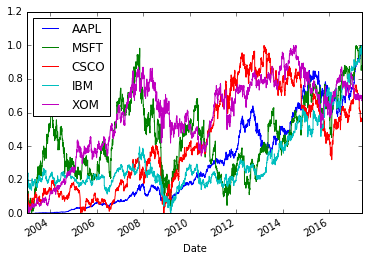

In [123]:
p.plot()
show()

In [124]:
def calc_signals(tickers,p,a,b):
    sma = p.rolling(a).mean()
    smb = p.rolling(b).mean()
    signal = np.sign(sma - smb).diff()
    actual_signals = signal[signal!=0].dropna(how='all',axis=0)
    for col in actual_signals.columns:
        idx = actual_signals[col].first_valid_index()
        signal[col][idx] = signal[col][idx]/2.
    return signal

In [125]:
def calc_pnl(sig,p):
    sig_up = sig.cumsum().apply(lambda x:x*(x>0))
    sig_dwn = sig.cumsum().apply(lambda x:x*(x<0))
    pnlx = cumsum(p.diff()*sig_up+p.diff()*sig_dwn).sum(axis=1)
    return pnlx

def calc_sharpe(pnl):
    '''We use absolute returns because we start with zero pnl, rel pnl would inflate initial rets'''
    retsx = diff(pnl)
    retsx = retsx[~isinf(retsx)]
    sharpe = np.nanmean(retsx)/np.nanstd(retsx)*sqrt(252)
    return sharpe
            
def calc_ddwn(pnl):
    hwm = 0
    ddwn = []
    for i in pnl:
        if i>hwm:
            hwm = i
        ddwn.append(i - hwm)
    return min(ddwn)
        
        
        
#sig = calc_signals(tickers,p,40,50)        
#pnl = calc_pnl(sig,p)
#calc_ddwn(pnl)
#print calc_sharpe(sig,p)
#plot(calc_pnl(sig,p))
#show()
#print sig.ix[40:70]
#print p.ix[40:]
#print pnl[-1]

In [126]:
# parameter sweep
def parameter_sweep(tickers,p,params,N):
    pnls = []
    sharpes = []
    ddwns = []
    for i in range(N):
        a = min(params[i])
        b = max(params[i])
        try:
            sig = calc_signals(tickers,p,a,b)
            
            pnl = calc_pnl(sig,p)
            pnls.append(pnl[-1])
            sharpes.append(calc_sharpe(pnl))
            ddwns.append(calc_ddwn(pnl))
            
        except:
            pnls.append(np.nan)
            sharpes.append(np.nan)
            ddwns.append(np.nan)
            
    return pnls,sharpes,ddwns

In [127]:
# parameter sweep
def parameter_sweep2(tickers,p,params,N):
    pnls = []
    for i in range(N):
        a = min(params[i])
        b = max(params[i])
        try:
            sig = calc_signals(tickers,p,a,b)
            pnls.append(calc_pnl(sig,p))
        except:
            pnls.append(np.nan)
    return pnls

In [187]:
# TODO: Parameter sweep behaves different from normal pnl calc
# THIS IS WITH NORMAL TRAIN/TEST PERIOD

N = 5000
sm = 5
lm = 250
frac = 0.7
mid_point = str(timedelta((parse(end)-parse(start)).days*frac)+parse(start))
print 'MID POINT:', mid_point
print 'BACKEND:',BACKEND
params = np.array([np.random.randint(sm,lm,(N,)) for i in range(2)]).T

p0 = prices(tickers,start,mid_point,backend=BACKEND)
pnls1,sharpes1,ddwns1 = parameter_sweep(tickers,p0,params,N)

p1 = prices(tickers,mid_point,end,backend=BACKEND)
pnls2,sharpes2,ddwns2 = parameter_sweep(tickers,p1,params,N)

MID POINT: 2013-02-02 12:00:00
BACKEND: google


In [130]:
# THIS IS WITH VARIABLE TEST PERIOD

"""N = 5000
sm = 15
lm = 195
params = np.array([np.random.randint(60,90,(N,)) for i in range(2)]).T
p = prices(tickers,start,end)
pnls = parameter_sweep2(tickers,p,params,N)
pnls1 = []
pnls2 = []

frac = 0.2
for pnl in pnls:

    assert(frac<1)
    try:
        a0 = random.randint(0,len(pnl)-round(len(pnl)*frac))
        a1 = int(a0 + round((len(pnl)*frac)))
        pnls1.append(pnl.ix[a0]+pnl.ix[-1])
        pnls2.append(pnl.ix[a1]-pnl.ix[a0])
    except:
        pnls1.append(0)
        pnls2.append(0)"""


'N = 5000\nsm = 15\nlm = 195\nparams = np.array([np.random.randint(60,90,(N,)) for i in range(2)]).T\np = prices(tickers,start,end)\npnls = parameter_sweep2(tickers,p,params,N)\npnls1 = []\npnls2 = []\n\nfrac = 0.2\nfor pnl in pnls:\n\n    assert(frac<1)\n    try:\n        a0 = random.randint(0,len(pnl)-round(len(pnl)*frac))\n        a1 = int(a0 + round((len(pnl)*frac)))\n        pnls1.append(pnl.ix[a0]+pnl.ix[-1])\n        pnls2.append(pnl.ix[a1]-pnl.ix[a0])\n    except:\n        pnls1.append(0)\n        pnls2.append(0)'

In [192]:
def remove_nans(inpts,vals):
    idx = []
    bad_idx = []
    new_inpts = []
    for n,inp in enumerate(inpts):
        for i,j in enumerate(inp):
            if np.isnan(j) or np.isinf(j):
                bad_idx.append(i)
                
    for i in range(len(inpts[0])):
        if not i in bad_idx:
            idx.append(i)
    
    for inp in inpts:
        new_inpts.append(array(inp)[unique(idx)])
        
    new_inpts.append(vals[unique(idx)])
    return new_inpts
print len(pnls1)
            
pnls1,pnls2,sharpes1,sharpes2,ddwns1,ddwns2,params = remove_nans([pnls1,pnls2,sharpes1,sharpes2,ddwns1,ddwns2],params)

5000


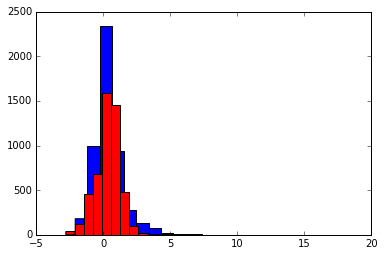

mean train pnl: 1.30337135842
mean test pnl: 0.545651147613
expected absoulte shortfall: -0.714598286059


In [193]:
plt.hist(pnls1,20,color='b')
plt.hist(pnls2,20,color='r')
show()
shortfall = mean(pnls1)/frac-mean(pnls2)/(1-frac)
print 'mean train pnl:', mean(pnls1)/(1-frac)
print 'mean test pnl:',mean(pnls2)/frac
print 'expected absoulte shortfall:',shortfall

In [194]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import calinski_harabaz_score



def get_cluster_number(X):
    score = 0 
    best_cluster_number = 0 
    for i in range(2,10):
        kmeans = AgglomerativeClustering(n_clusters = i)
        kmeans.fit(X)
        chs = calinski_harabaz_score(X,kmeans.labels_)
        if chs>score:
            best_cluster_number = i 
            score = chs 
    return best_cluster_number

Nc = get_cluster_number(np.array([pnls1,pnls2]).T)
kmeans = KMeans(n_clusters=Nc).fit(np.array([pnls1,pnls2]).T)

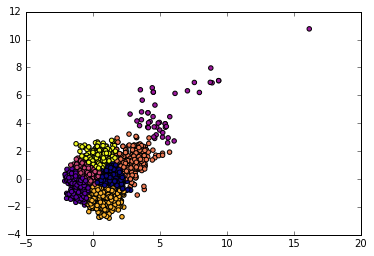

In [195]:
plt.scatter(pnls1,pnls2,c=kmeans.labels_,cmap='plasma');
show()

In [196]:
# Which cluster has the highest OOS pnl?

def find_best_cluster(kmeans):
    median_oos_pnl = []
    for label in np.unique(kmeans.labels_):
        median_pnl = median(pnls2[kmeans.labels_==label])
        median_oos_pnl.append(median_pnl)
    center_mean = argmax(mean(kmeans.cluster_centers_,axis=1))                         
    opt_label = argmax(median_oos_pnl)
    if center_mean!=opt_label:
        print 'Warning: best center mean is different from median oos pnl'
    return opt_label
    
opt_label = find_best_cluster(kmeans)

In [197]:
plt.scatter(pnls1[kmeans.labels_==opt_label],pnls2[kmeans.labels_==opt_label]);

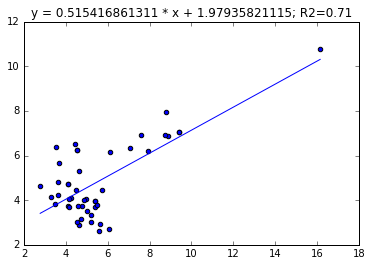

predicted shortfall: 0.484583138689


In [198]:
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(pnls1[kmeans.labels_==opt_label],pnls2[kmeans.labels_==opt_label])
xx = np.linspace(min(pnls1[kmeans.labels_==opt_label]),max(pnls1[kmeans.labels_==opt_label]),100)
yy = polyval([slope,intercept],xx)
plot(xx,yy)
plt.title('y = %s * x + %s; R2=%s'%(slope,intercept,round(r_value,2)))
show()
print 'predicted shortfall:',1-slope

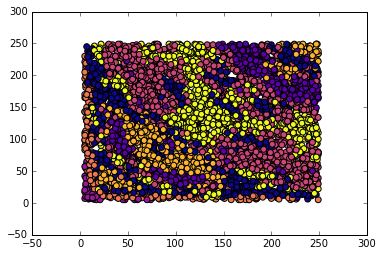

In [199]:
plt.scatter(np.array(params)[:,0],np.array(params)[:,1],c=kmeans.labels_,cmap='plasma',s=35)
show()

In [200]:
best_center = kmeans.cluster_centers_[opt_label]

# Find strategies around cluster centers
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(3)
neigh.fit(np.array([pnls1,pnls2]).T,best_center)
dist,idx = neigh.kneighbors([best_center],15,return_distance=True)

# This is because we sometimes have larger and smaller lkbk reversed but sorted in the pnl calc, and we don't
# want to duplicate this.
unique_params = np.unique(map(sort,params[idx][0]),axis=0)
unique_params

In [201]:
idx = argsort(pnls2)
unique_params = np.unique(params[idx][-15:],axis=0)
unique_params

array([[ 5,  7],
       [ 5, 17],
       [ 5, 20],
       [ 6, 10],
       [ 8,  9],
       [ 8, 13],
       [ 9,  6],
       [10,  7],
       [11,  8],
       [13,  8],
       [14,  6],
       [14,  7],
       [15,  6],
       [17,  5],
       [21,  5]])

19.2860787726 2.29453643332
11.3902532822 1.35234730134
10.7291915802 1.29898779231
9.95085716968 1.18300285148
7.55065242655 0.879796964773
7.17180749082 0.85444990771
11.1009583753 1.30623830319
6.54378938179 0.770568783293
6.34057764974 0.754673448497
7.17180749082 0.85444990771
8.80833038968 1.05043560251
8.00844490247 0.946973494818
9.48420789966 1.11794994327
11.3902532822 1.35234730134
10.7213881325 1.3007253895


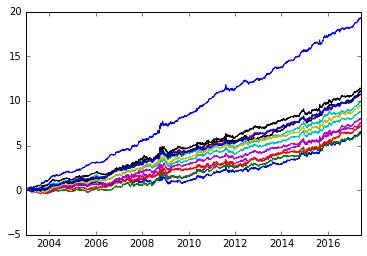

In [202]:
#calc_pnl(calc_signals(tickers,p,unique_params[idx][0][2][0],unique_params[idx][0][2][1]),p)
for par in unique_params:
    pnl = (calc_pnl(calc_signals(tickers,p,min(par),max(par)),p))
    print pnl[-1],
    print (calc_sharpe(calc_pnl(calc_signals(tickers,p,min(par),max(par)),p)))
    plot((calc_pnl(calc_signals(tickers,p,min(par),max(par)),p)))
show()

In [203]:
"""manual_score = []
eject = False
for sharpe,ddwn,pnl in zip(sharpes1,ddwns1,pnls1):
    do_again = True
    if eject: break
    if sharpe > 0 and pnl>30:
        while do_again:
            try:
                print 'shrp:',sharpe,'  ddwn:',ddwn,'  pnl:',pnl
                ip = raw_input()
                if ip == 'stop': 
                    eject = True
                    do_again = False
                manual_score.append(float(ip))
                do_again = False
            except:
                do_again = True
    else:
            manual_score.append(0)"""

"manual_score = []\neject = False\nfor sharpe,ddwn,pnl in zip(sharpes1,ddwns1,pnls1):\n    do_again = True\n    if eject: break\n    if sharpe > 0 and pnl>30:\n        while do_again:\n            try:\n                print 'shrp:',sharpe,'  ddwn:',ddwn,'  pnl:',pnl\n                ip = raw_input()\n                if ip == 'stop': \n                    eject = True\n                    do_again = False\n                manual_score.append(float(ip))\n                do_again = False\n            except:\n                do_again = True\n    else:\n            manual_score.append(0)"

actual pnl: 19.2860787726  bootstrapped mean pnl:  19.3787807778


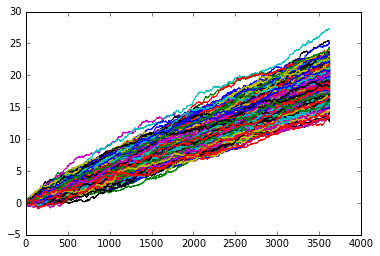

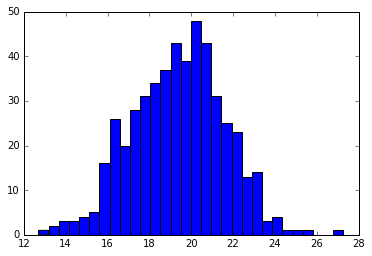

In [204]:
# BOOTSTRAPPING
pnl = (calc_pnl(calc_signals(tickers,p,unique_params[0][0],unique_params[0][1]),p))
rets = pnl.diff()
rets = rets[~np.isnan(rets)]
last = []
for i in range(500):
    k = random.choice(rets,len(rets))
    ps = cumsum(k)
    if ~np.isnan(ps[-1]):
        last.append(ps[-1])
    plot(ps)
print 'actual pnl:',cumsum(rets)[-1],' bootstrapped mean pnl: ',np.nanmean(last)
show()
hist(last,30)
show()

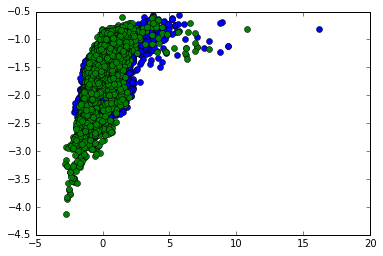

In [205]:
plot(pnls1,ddwns1,'o')
plot(pnls2,ddwns2,'o')
show()

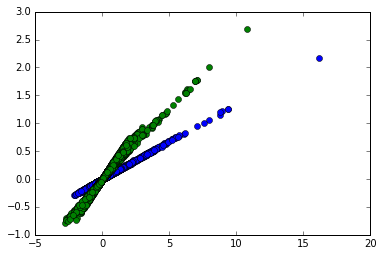

In [211]:
plot(pnls1,sharpes1,'o')
plot(pnls2,sharpes2,'o')
show()

In [216]:
# explore the response surface around the best parameter to see how robust the pnl is.
import scipy
x = []; y = []; z = []
k = 3
for i in range(-k,k):
    for k in range(-k,k):
        u = unique_params[0]+[i,k]
        if not u[0] == u[1] and not u[0]>u[1]:
            pnl = calc_pnl(calc_signals(tickers,p,u[0],u[1]),p)[-1]
            x.append(u[0])
            y.append(u[1])
            z.append(pnl)

n_points = 50
X,Y = np.meshgrid(linspace(min(x),max(x),n_points),linspace(min(y),max(y),n_points))
Z = scipy.interpolate.griddata(array([x,y]).T,array(z),(X,Y),method='cubic')

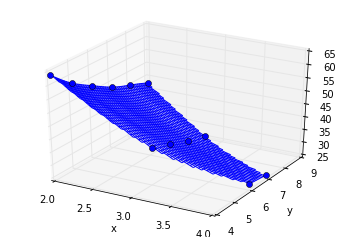

In [217]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x,y,z,'o')
ax.plot_wireframe(X,Y,Z)
xlabel('x');ylabel('y')
show()